In [6]:
import matplotlib.pyplot as plt
import pickle
import numpy as np
import sys
import os
import pandas as pd
import seaborn as sns
import matplotlib.colors as colors
import matplotlib.cm as cmx

from scipy.optimize import curve_fit
from scipy.fft import fft, fftfreq


# plot speedscaling for all wBA

In [8]:
home = os.path.expanduser("~")

# net = f'fb_linear'
net = f'fb_linear'
filepath = f'{home}/Documents/Simulations/motion_anticipation_network/{net}'

# load dataframe 
response_data = pd.read_csv(f'{filepath}/responses_RB_wAB.csv')


# load dataframe 
df = pd.read_csv(f'{filepath}/anticipation_data_wAB.csv')


print(df.columns)

# calculate anticipation with respect to V_drive
df['ant_RG_drive_time']  =  df['peak_drive'] - df['peak_RG'] 
df['ant_RG_drive_space'] = df['ant_RG_drive_time']* df['speed']

# calculate anticipation with respect to 
df['ant_RG_bar_time']  = df['tp_rf_GC_mid'] - df['peak_RG'] 
df['ant_RG_bar_space'] = df['ant_RG_bar_time']* df['speed']

# calculate anticipation with respect to 
df['ant_RB_bar_time']  = df['tp_rf_GC_mid'] - df['peak_RB'] 
df['ant_RB_bar_space'] = df['ant_RB_bar_time']* df['speed']



df['wTOT'] = df['wTOT']
df['wTOT'] = df['wTOT'].round()
df['speed'] = df['speed'].round(2)
# multiple heatmaps, keeping w+ fixed and changing w-
#dfgrouped = df.groupby(['wAB'])


speeds = df['speed'].unique()#[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,2.0]

df['wBA'].unique(), df['wAB'].unique()



FileNotFoundError: [Errno 2] No such file or directory: '/Users/simoneebert/Documents/Simulations/motion_anticipation_network/fb_linear/responses_RB_wAB.csv'

In [4]:

def main_frequency(signal, sampling_rate):

    """
    Calculate the main frequency of a signal.

    Parameters:
    signal (numpy array): The input signal (time domain).
    sampling_rate (float): The sampling rate of the signal in Hz.

    Returns:
    float: The main frequency of the signal in Hz.
    """
    
    # Number of samples in the signal
    N = len(signal)

    # Perform the Fast Fourier Transform (FFT)
    fft_values = fft(signal)

    # Get the corresponding frequencies
    frequencies = fftfreq(N, d=1/sampling_rate)

    # Only consider the positive frequencies (as FFT produces symmetric output)
    positive_frequencies = frequencies[:N // 2]
    positive_fft_values = np.abs(fft_values[:N // 2])

    # Find the frequency with the maximum amplitude in the FFT result
    main_freq_index = np.argmax(positive_fft_values)
    main_freq = positive_frequencies[main_freq_index]

    return main_freq


In [3]:
df['wTOT'].unique()

NameError: name 'df' is not defined

In [4]:
# dl = df[df['wBA'] == 1.0]
# #dl = df[df['wTOT'] == -101.0]
# #dl = dl[dl['speed'] == 1.05]
# idx = dl['ant_RG_bar_space'].index
# len(idx)


# for x,i in enumerate(idx):


#     r = response_data[f'{i}'].dropna()
#     tps = len(r)
#     speed = dl['speed'][dl.index[x]]
#     print(tps,speed)
#     tpm = dl['tp_rf_GC_mid'][dl.index[x]]
#     print(tpm)
#     time = (np.arange(0,tps)*0.01 -tpm)*speed
#     plt.plot(time,r,label = f'{i}')
# plt.legend()


In [5]:

fig = plt.figure(figsize = (15,15))
gs = fig.add_gridspec(2,3)

fig.subplots_adjust(wspace = 0.5,hspace = 0.5)

cmapg = plt.get_cmap('hsv', len(df['wTOT'].unique()))
cmapb = plt.get_cmap('hsv', len(df['wTOT'].unique()))

cNorm = colors.Normalize(vmin =df['wTOT'].min(), vmax = df['wTOT'].max())
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cmapb)

cbar_ax2 = fig.add_axes([.91, .2, .03, .2])
cbar_ax2.set_ylabel(r'$w$')
fig.colorbar(scalarMap,
             cax=cbar_ax2, orientation='vertical', label=r'$w$')





var = 'ant_RB_bar_space'
ax = fig.add_subplot(gs[0,0])
#weights = [0.0,10.0,50.0,100.0]


subg = df.groupby(['wTOT'])
#ax.set_xscale('log')

# get values for which difference across speed is minimal
diffsdf = pd.DataFrame(columns = ['diff', 'mu','wTOT','tauTOT', 'tauA', 'wAB'])
pref_speeds_B = []
pref_amp_B = []
weights_B = []
anipis_B = []

best_weights_B = []
vals_B = []
best_amp_B = []

# get values that yield same anticipation time across speeds
for x,w2 in enumerate(subg.groups):
    sg = subg.get_group(w2)

    cur  = sg[var].values
    speeds = sg['speed'].values
    maxi = np.argmax(cur)
    ax.plot(sg['speed'], sg[var],color = cmapb(x))#,color = scalarMap.to_rgba(x))
    ax.scatter(speeds[maxi],cur[maxi],color = cmapb(x), edgecolor = 'k', zorder = 10)

    pref_speeds_B.append(speeds[maxi])
    pref_amp_B.append(cur[maxi])
    weights_B.append(w2)
    anipis_B.append(cur)


anipis_B = np.asarray(anipis_B)
goal = 0.01
for i in range(len(speeds)):
    
    try:
        best_idx_upper = np.nonzero(anipis_B[:,i] >=goal)[0][0]
        best_aniup_er = np.abs(anipis_B[best_idx_upper,i]-goal)
    except:
        best_aniup_er = 100

    try: 
        best_idx_lower = np.nonzero(anipis_B[:,i] <=goal)[0][-1]
        best_anilo_er = np.abs(anipis_B[best_idx_lower,i]-goal)
    except: 
        best_anilo_er = 100

    if best_aniup_er > best_anilo_er:
        best_weight = weights_B[best_idx_lower]
        best_ani = anipis_B[best_idx_lower,i]
    else:
        best_weight = weights_B[best_idx_upper]
        best_ani = anipis_B[best_idx_upper,i]

    best_weights_B.append(best_weight)

    vals_B.append(best_ani)
    best_amp_B.append(best_ani)
    # ax.scatter(speeds[i],best_ani, marker = 'x', color = 'r')

#ax.legend()
plt.axhline(0.0, color = 'k')
# plt.axhline(goal, color = 'r')
ax.set_xlabel('speed [mm/s]')
ax.set_ylabel(r'$\Delta X$')
# figure.legend(bbox_to_anchor = (1.2,1))






weights = np.asarray(weights_B)
pref_speeds = np.asarray(pref_speeds_B)

def preferred_speed(wplus,alpha,beta):

    return alpha*np.sqrt(wplus)+beta


popt,_ = curve_fit(preferred_speed,weights,pref_speeds)

ax = fig.add_subplot(gs[0,1])
ax.set_title('Bipolar')
for wi,w in enumerate(weights):
    plt.scatter(w,pref_speeds[wi], color = cmapg(wi), edgecolor = 'k', zorder = 10)
plt.plot(weights, preferred_speed(weights,*popt), label  =f'optimal fit: alpha = {np.round(popt[0],2)}, beta = {np.round(popt[1],2)}', color = 'k')

plt.xlabel('w')
plt.legend()

ax = fig.add_subplot(gs[0,2])
ax.set_title(' ')
for wi,w in enumerate(weights):
    plt.scatter(w,pref_amp_B[wi], color = cmapg(wi), edgecolor = 'k', zorder = 10)

plt.xlabel('w')


NameError: name 'df' is not defined

<Figure size 1500x1500 with 0 Axes>

## optimal weight for a set amout of anticipation 

In [9]:

# fig = plt.figure()
# gs = fig.add_gridspec(2,3)


# ax = fig.add_subplot(gs[0,0])
# plt.plot(speeds,best_weights_B)
# plt.scatter(speeds,best_weights_B)

# ax = fig.add_subplot(gs[0,1])
# plt.plot(speeds,vals_B)


# ax = fig.add_subplot(gs[0,2])
# plt.plot(speeds,vals_B)




# ax = fig.add_subplot(gs[1,0])
# plt.plot(speeds,best_weights_G)
# plt.scatter(speeds,best_weights_G)

# ax = fig.add_subplot(gs[1,1])
# plt.plot(speeds,vals_G)


# ax = fig.add_subplot(gs[1,2])
# plt.plot(speeds,vals_G)

## weight for preferred speed

Text(0.5, 0, 'w')

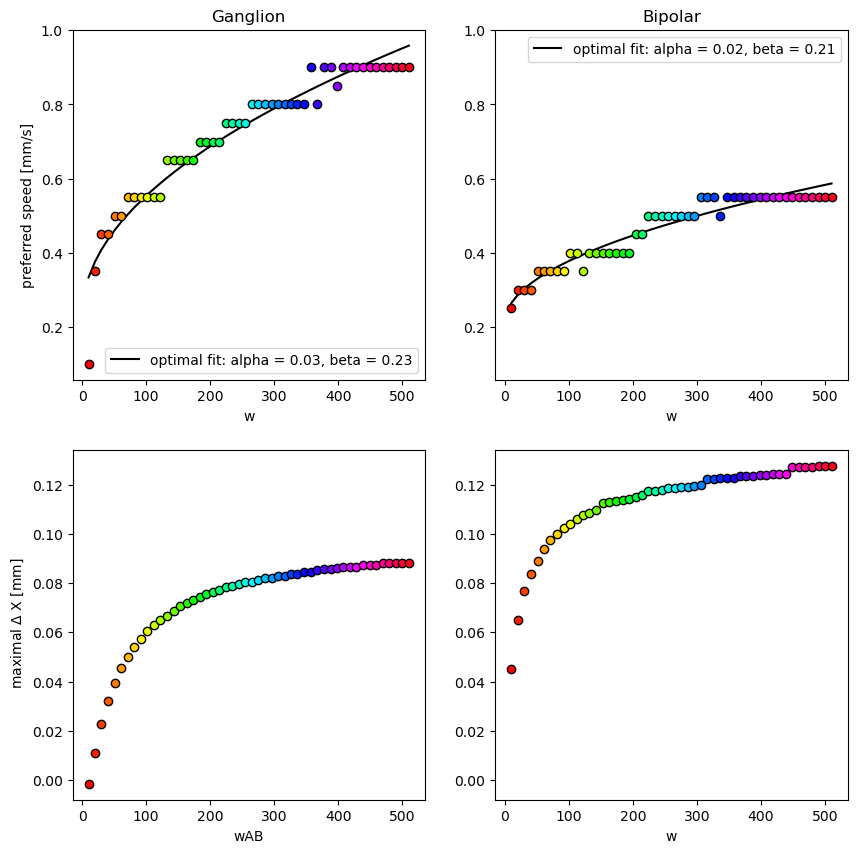

In [10]:

def preferred_speed(wplus,alpha,beta):

    return alpha*np.sqrt(wplus)+beta



fig = plt.figure(figsize = (10,10))
gs = fig.add_gridspec(2,2)




# weights = np.asarray(weights_G)  # bc w = wAB*wBA
# pref_speeds = np.asarray(pref_speeds_G)
# popt,_ = curve_fit(preferred_speed,weights,pref_speeds)



# ax = fig.add_subplot(gs[0,0])

# ax.set_title('Ganglion')
# for wi,w in enumerate(weights):
#     plt.scatter(w,pref_speeds[wi], color = cmapg(wi), edgecolor = 'k', zorder = 10)
# plt.plot(weights, preferred_speed(weights,*popt), label  =f'optimal fit: alpha = {np.round(popt[0],2)}, beta = {np.round(popt[1],2)}', color = 'k')

# plt.xlabel('w')
# plt.ylabel('preferred speed [mm/s]')
# plt.legend()

# axs = ax




# ax = fig.add_subplot(gs[1,0])
# ax.set_title('')
# for wi,w in enumerate(weights):
#     plt.scatter(w,pref_amp_G[wi], color = cmapg(wi), edgecolor = 'k', zorder = 10)


# plt.xlabel('wAB')
# plt.ylabel(r' maximal $\Delta$ X [mm]')

# axa = ax





weights = np.asarray(weights_B)
pref_speeds = np.asarray(pref_speeds_B)

def preferred_speed(wplus,alpha,beta):

    return alpha*np.sqrt(wplus)+beta


popt,_ = curve_fit(preferred_speed,weights,pref_speeds)



ax = fig.add_subplot(gs[0,1],sharey = axs)

ax.set_title('Bipolar')
for wi,w in enumerate(weights):
    plt.scatter(w,pref_speeds[wi], color = cmapg(wi), edgecolor = 'k', zorder = 10)
plt.plot(weights, preferred_speed(weights,*popt), label  =f'optimal fit: alpha = {np.round(popt[0],2)}, beta = {np.round(popt[1],2)}', color = 'k')

plt.xlabel('w')
plt.legend()


ax = fig.add_subplot(gs[1,1],sharey = axa)
ax.set_title(' ')
for wi,w in enumerate(weights):
    plt.scatter(w,pref_amp_B[wi], color = cmapg(wi), edgecolor = 'k', zorder = 10)

plt.xlabel('w')

In [11]:
# df['wTOT'].unique()
# dl = df[df['wTOT'] == 10.]
# dl
# s = dl['speed'].unique()[0]
# dl = dl[dl['speed'] == s]
# idx = dl['ant_RG_bar_space'].index[0]
# response_data[f'{idx}']
plt.close()


In [12]:
# calculate frequency of response
mfrqs  = np.zeros((len(df['wTOT'].unique()),len(df['speed'].unique())))
for ro,w in enumerate(df['wTOT'].unique()):
#get all response for one weight 
    dl = df[df['wTOT'] == w]

    # # get idx per speed
    # plt.figure()
    # plt.title(f'{w}')
    for co,s in enumerate(dl['speed'].unique()):
        dk = dl[dl['speed'] == s]
        idx = dk['ant_RG_bar_space'].index[0]

        r = response_data[f'{idx}'].dropna().values

        # plt.plot(r)
        freq = main_frequency(r,1/0.01)
        mfrqs[ro,co] = freq




# # plot frequency per speed
# # highligh max ant


# # plot anticipation per speed
# # highligt max ant 

# response_data.keys()

In [13]:
np.random.randn(1)

array([-0.46520468])

In [14]:
%matplotlib qt
for ro,w in enumerate(df['wTOT'].unique()):
    plt.plot(speeds,mfrqs[ro,:]+np.random.randn(1)*0.01,color = cmapg(ro),alpha = 0.4)
    plt.axvline(pref_speeds_G[ro],color = cmapg(ro),alpha = 0.4)

# plot speedscaling for all tauA/B, relative difference

In [15]:
net = f'fb_linear'

# load dataframe 
response_data = pd.read_csv(f'{filepath}/responses_RG_tauABrel.csv')

# load dataframe 
df = pd.read_csv(f'{filepath}/anticipation_data_tauABrel.csv')

print(df.columns)



# calculate anticipation with respect to V_drive
df['ant_RG_drive_time']  =  df['peak_drive'] - df['peak_RG'] 
df['ant_RG_drive_space'] = df['ant_RG_drive_time']* df['speed']

# calculate anticipation with respect to 
df['ant_RG_bar_time']  = df['tp_rf_GC_mid'] - df['peak_RG'] 
df['ant_RG_bar_space'] = df['ant_RG_bar_time']* df['speed']



# calculate anticipation with respect to 
df['ant_RB_bar_time']  = df['tp_rf_GC_mid'] - df['peak_RB'] 
df['ant_RB_bar_space'] = df['ant_RB_bar_time']* df['speed']

df['wTOT'] = -1*df['wTOT']
df['wTOT'] = df['wTOT'].round()
# multiple heatmaps, keeping w+ fixed and changing w-
#dfgrouped = df.groupby(['wAB'])

speeds = df['speed'].unique()#[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,2.0]

df['tauA'].unique()



Index(['Unnamed: 0', 'wTOT', 'tauTOT', 'wBA', 'wAB', 'tauA', 'tauB', 'mu',
       'speed', 'peak_RG', 'peak_RB', 'peak_drive', 'tp_rf_GC_mid',
       'peak_RG_pooling', 'peak_RB_pooling', 'onset_RB', 'onset_RG', 'x',
       'wGA'],
      dtype='object')


array([0.087, 0.089, 0.092, 0.095, 0.097, 0.101, 0.104, 0.107, 0.111,
       0.115, 0.119, 0.124, 0.129, 0.134, 0.14 , 0.146, 0.153, 0.161,
       0.169, 0.178, 0.189, 0.201, 0.214, 0.229, 0.247, 0.267, 0.291,
       0.32 , 0.356, 0.4  ])

In [16]:
# dl = df[df['tauA'] == 0.4]
# #dl = df[df['wTOT'] == -101.0]
# # dl = dl[dl['speed'] == 1.0 ]
# idx = dl['ant_RG_bar_space'].index
# len(idx)


# for x,i in enumerate(idx):


#     r = response_data[f'{i}'].dropna()
#     tps = len(r)
#     speed = dl['speed'][dl.index[x]]
#     print(tps,speed)
#     tpm = dl['tp_rf_GC_mid'][dl.index[x]]
#     print(tpm)
#     time = (np.arange(0,tps)*0.01 -tpm)*speed
#     plt.plot(time,r,label = f'{i}')
# plt.legend()

In [17]:


figure = plt.figure(figsize = (15,15))
gs = figure.add_gridspec(2,2)

figure.subplots_adjust(wspace = 0.5,hspace = 0.5)


cmapg = plt.get_cmap('hsv', len(df['tauTOT'].unique()))
cmapb = plt.get_cmap('hsv', len(df['tauTOT'].unique()))

cNorm = colors.Normalize(vmin =df['tauTOT'].min(), vmax = df['tauTOT'].max())
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cmapb)

cbar_ax2 = figure.add_axes([.91, .2, .03, .2])
cbar_ax2.set_ylabel(r'$\tau$')
figure.colorbar(scalarMap,
             cax=cbar_ax2, orientation='vertical', label=r'$\tau$')

var = 'ant_RG_bar_space'
fig = figure.add_subplot(gs[0,0])
fig.set_title('Gangion Anticipation')
ax = figure.add_subplot(gs[1,0])
#weights = [0.0,10.0,50.0,100.0]

# plot heatmap for beta
g_heatmap = df.pivot_table(index = 'tauTOT',columns = 'speed',values = var, aggfunc = 'mean')
sns.heatmap(g_heatmap, ax = fig, cmap = 'bwr')#,  vmin=-0.2, vmax=0.2)

subg = df.groupby(['tauA'])
#ax.set_xscale('log')


# get values for which difference across speed is minimal
diffsdf = pd.DataFrame(columns = ['diff', 'mu','wTOT','tauTOT', 'tauA', 'wAB'])
pref_speeds_G = []
pref_amp_G = []
weights_G = []
anips_G = []

best_weights_G = []
vals_G = []
best_amp_G = []

# get values that yield same anticipation time across speeds
for x,w2 in enumerate(subg.groups):
    sg = subg.get_group(w2)

    cur  = sg[var].values
    speeds = sg['speed'].values
    maxi = np.argmax(cur)
    ax.plot(sg['speed'], sg[var], label = f'tauTOT = {w2}',color = cmapg(x))
    ax.scatter(speeds[maxi],cur[maxi],color = cmapg(x), edgecolor = 'k', zorder = 10)

    pref_speeds_G.append(speeds[maxi])
    pref_amp_G.append(cur[maxi])
    weights_G.append(w2)
    anips_G.append(cur)

anipis_G = np.asarray(anips_G)
goal = 0.01
for i in range(len(speeds)):
    
    try:
        best_idx_upper = np.nonzero(anipis_G[:,i] >=goal)[0][0]
        best_aniup_er = np.abs(anipis_G[best_idx_upper,i]-goal)
    except:
        best_aniup_er = 100

    try: 
        best_idx_lower = np.nonzero(anipis_G[:,i] <=goal)[0][-1]
        best_anilo_er = np.abs(anipis_G[best_idx_lower,i]-goal)
    except: 
        best_anilo_er = 100

    if best_aniup_er > best_anilo_er:
        best_weight = weights_G[best_idx_lower]
        best_ani = anipis_G[best_idx_lower,i]
    else:
        best_weight = weights_G[best_idx_upper]
        best_ani = anipis_G[best_idx_upper,i]

    best_weights_G.append(best_weight)

    vals_G.append(best_ani)
    best_amp_G.append(best_ani)
    # ax.scatter(speeds[i],best_ani, marker = 'x', color = 'r')

#ax.legend()
plt.axhline(0.0, color = 'k')
# plt.axhline(goal, color = 'r')
ax.set_xlabel('speed [mm/s]')
ax.set_ylabel(r'$\Delta X$')




var = 'ant_RB_bar_space'
fig = figure.add_subplot(gs[0,1])
fig.set_title('Bipolar Anticipation')
ax = figure.add_subplot(gs[1,1])
#weights = [0.0,10.0,50.0,100.0]

# plot heatmap for beta
g_heatmap = df.pivot_table(index = 'tauTOT',columns = 'speed',values = var, aggfunc = 'mean')
sns.heatmap(g_heatmap, ax = fig, cmap = 'bwr')#,  vmin=-0.2, vmax=0.2)

subg = df.groupby(['tauA'])
#ax.set_xscale('log')


# get values for which difference across speed is minimal
diffsdf = pd.DataFrame(columns = ['diff', 'mu','wTOT','tauTOT', 'tauA', 'wAB'])
pref_speeds_B = []
pref_amp_B = []
weights_B = []
anipis_B = []

best_weights_B = []
vals_B = []
best_amp_B = []

# get values that yield same anticipation time across speeds
for x,w2 in enumerate(subg.groups):
    sg = subg.get_group(w2)

    cur  = sg[var].values
    speeds = sg['speed'].values
    maxi = np.argmax(cur)
    ax.plot(sg['speed'], sg[var],color = cmapb(x))#,color = scalarMap.to_rgba(x))
    ax.scatter(speeds[maxi],cur[maxi],color = cmapb(x), edgecolor = 'k', zorder = 10)

    pref_speeds_B.append(speeds[maxi])
    pref_amp_B.append(cur[maxi])
    weights_B.append(w2)
    anipis_B.append(cur)


anipis_B = np.asarray(anipis_B)
goal = 0.01
for i in range(len(speeds)):
    
    try:
        best_idx_upper = np.nonzero(anipis_B[:,i] >=goal)[0][0]
        best_aniup_er = np.abs(anipis_B[best_idx_upper,i]-goal)
    except:
        best_aniup_er = 100

    try: 
        best_idx_lower = np.nonzero(anipis_B[:,i] <=goal)[0][-1]
        best_anilo_er = np.abs(anipis_B[best_idx_lower,i]-goal)
    except: 
        best_anilo_er = 100

    if best_aniup_er > best_anilo_er:
        best_weight = weights_B[best_idx_lower]
        best_ani = anipis_B[best_idx_lower,i]
    else:
        best_weight = weights_B[best_idx_upper]
        best_ani = anipis_B[best_idx_upper,i]

    best_weights_B.append(best_weight)

    vals_B.append(best_ani)
    best_amp_B.append(best_ani)
    # ax.scatter(speeds[i],best_ani, marker = 'x', color = 'r')



#ax.legend()
plt.axhline(0.0, color = 'k')
# plt.axhline(goal, color = 'r')
ax.set_xlabel('speed [mm/s]')
ax.set_ylabel(r'$\Delta X$')
# figure.legend(bbox_to_anchor = (1.2,1))


# fig = plt.figure()
# fig.tight_layout()

# fig.suptitle(f'{var} for tauA and speeds')
# var = 'ant_RG_bar_space'

# fig2 = plt.figure()
# fig2.tight_layout()
# #weights = [0.0,10.0,50.0,100.0]

# ax = fig.add_subplot(1,1,1)
# # plot heatmap for beta
# g_heatmap = df.pivot_table(index = 'tauA',columns = 'speed',values = var, aggfunc = 'mean')
# sns.heatmap(g_heatmap, ax = ax, cmap = 'bwr')#,  vmin=-0.2, vmax=0.2)

# subg = df.groupby(['tauA'])
# ax = fig2.add_subplot(1,1,1)
# ax.set_xscale('log')


# # get values for which difference across speed is minimal
# diffsdf = pd.DataFrame(columns = ['diff', 'mu','wTOT','tauTOT', 'tauA', 'wBA'])


# # get values that yield same anticipation time across speeds
# for x,w2 in enumerate(subg.groups):
#     sg = subg.get_group(w2)

#     cur  = sg[var].values
#     speeds = sg['speed'].values
#     maxi = np.argmax(cur)
#     ax.plot(sg['speed'], sg[var])
#     print(len(sg['speed']))
#     ax.scatter(speeds[maxi],cur[maxi])
#     # diff = np.mean(np.abs(np.diff(sg[var])))
#     # data = {'diff': diff,
#     #         'mu' : w2,
#     #         'wTOT': sg['wTOT'].min(),
#     #         'tauTOT': sg['tauTOT'].min(),
#     #         'tauA':sg['tauA'],
#     #         'wBA': sg['wBA']}
#     # diffsdf = diffsdf._append(data, ignore_index = True)
#     # if x == 3:
#     #     break

# ax.legend()



/tmp/ipykernel_552755/2105862163.py:45: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  sg = subg.get_group(w2)
/tmp/ipykernel_552755/2105862163.py:123: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  sg = subg.get_group(w2)


Text(847.5972222222223, 0.5, '$\\Delta X$')

Text(0.5, 0, '$\\tau$')

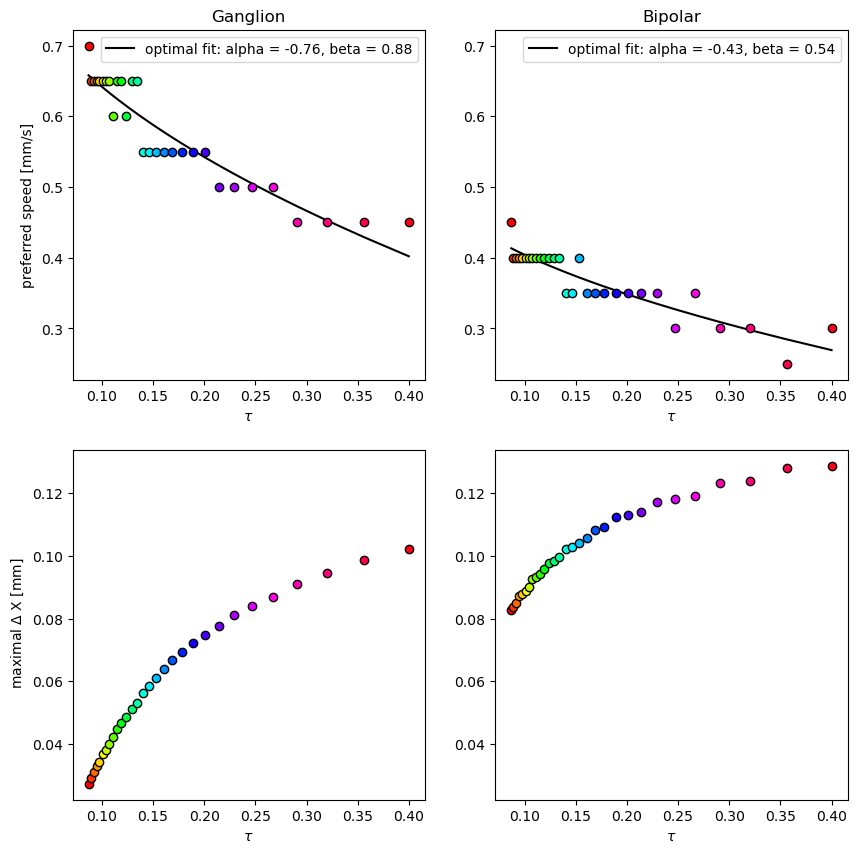

In [11]:

def preferred_speed(wplus,alpha,beta):

    return alpha*np.sqrt(wplus)+beta



fig = plt.figure(figsize = (10,10))
gs = fig.add_gridspec(2,2)




weights = np.asarray(weights_G)
pref_speeds = np.asarray(pref_speeds_G)
popt,_ = curve_fit(preferred_speed,weights,pref_speeds)



ax = fig.add_subplot(gs[0,0])

ax.set_title('Ganglion')
for wi,w in enumerate(weights):
    plt.scatter(w,pref_speeds[wi], color = cmapg(wi), edgecolor = 'k', zorder = 10)
plt.plot(weights, preferred_speed(weights,*popt), label  =f'optimal fit: alpha = {np.round(popt[0],2)}, beta = {np.round(popt[1],2)}', color = 'k')

plt.xlabel(r'$\tau$')
plt.ylabel('preferred speed [mm/s]')
plt.legend()

axs = ax




ax = fig.add_subplot(gs[1,0])
ax.set_title('')
for wi,w in enumerate(weights):
    plt.scatter(w,pref_amp_G[wi], color = cmapg(wi), edgecolor = 'k', zorder = 10)


plt.xlabel(r'$\tau$')
plt.ylabel(r' maximal $\Delta$ X [mm]')

axa = ax





weights = np.asarray(weights_B)
pref_speeds = np.asarray(pref_speeds_B)

def preferred_speed(wplus,alpha,beta):

    return alpha*np.sqrt(wplus)+beta


popt,_ = curve_fit(preferred_speed,weights,pref_speeds)



ax = fig.add_subplot(gs[0,1],sharey = axs)

ax.set_title('Bipolar')
for wi,w in enumerate(weights):
    plt.scatter(w,pref_speeds[wi], color = cmapg(wi), edgecolor = 'k', zorder = 10)
plt.plot(weights, preferred_speed(weights,*popt), label  =f'optimal fit: alpha = {np.round(popt[0],2)}, beta = {np.round(popt[1],2)}', color = 'k')

plt.xlabel(r'$\tau$')
plt.legend()


ax = fig.add_subplot(gs[1,1],sharey = axa)
ax.set_title(' ')
for wi,w in enumerate(weights):
    plt.scatter(w,pref_amp_B[wi], color = cmapg(wi), edgecolor = 'k', zorder = 10)

plt.xlabel(r'$\tau$')

In [12]:
len(df['tauA'].unique())


30

# TODO speedscaling for all tauA/B with absolute values changing, but tau staying the same